In [14]:
import numpy as np
import matplotlib.pyplot as plt

from ya_pca.linalg_utils import svd_wrapper
from ya_pca.toy_data import perry_sim_dist, rand_factor_model
from ya_pca.viz import scree_plot

from ya_pca.rank_selection.noise_estimates import estimate_noise_mp_quantile, \
    estimate_noise_soft_impute

from ya_pca.rank_selection.rmt_threshold import select_rank_rmt_threshold, donoho_gavish_threshold,\
    marcenko_pastur_edge_threshold
from ya_pca.rank_selection.bai_ng_bic import select_rank_bai_ng_bic
from ya_pca.rank_selection.bi_cv import select_rank_bi_cv
from ya_pca.rank_selection.wold_cv import select_rank_wold_cv
from ya_pca.rank_selection.profile_likelihood import select_rank_prof_lik
from ya_pca.rank_selection.horn import select_rank_horn, plot_horn
from ya_pca.rank_selection.variance_explained import \
    select_rank_variance_explained
from ya_pca.rank_selection.minka import select_rank_minka


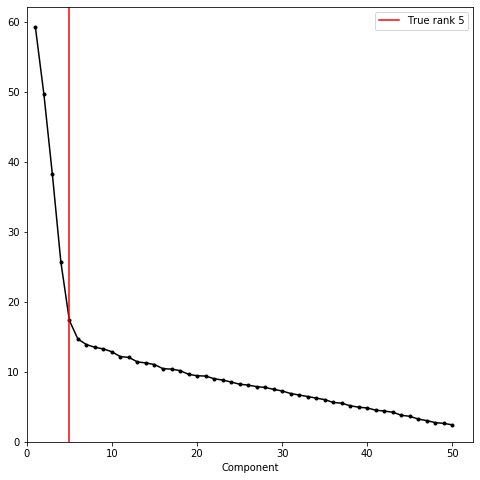

In [59]:
rank_true = 5
X, out = rand_factor_model(n_samples=80, n_features=50, rank=rank_true, sigma=1,
                           m=1.5, random_state=213)

# X, out = perry_sim_dist(strong=False, sparse=True, noise='white', random_state=5)
# rank_true = 6


n, d = X.shape

U, svals, V = svd_wrapper(X)

plt.figure(figsize=(8, 8))
scree_plot(svals, color='black')
plt.ylim(0)
plt.axvline(rank_true, label='True rank {}'.format(rank_true), color='red')
plt.legend()

# sigma_est = estimate_noise_mp_median(svals=svals, shape=X.shape)
# print('Noise estimate', sigma_est)

# Proporiton of variance explained

Estimated rank 40


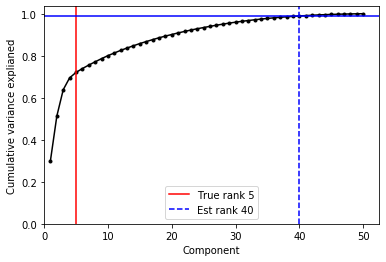

In [60]:
q=0.99
rank_est, out = select_rank_variance_explained(X, svals, q=q)
print("Estimated rank", rank_est)


var_expl_cum = out['var_expl_cum']
# rank = np.arange(1, len(var_expl_cum) + 1)
# plt.plot(rank, var_expl_cum, marker='.', color='black')
scree_plot(var_expl_cum, color='black')
plt.ylim(0)
plt.ylabel("Cumulative variance explianed")
plt.axvline(rank_true, label='True rank {}'.format(rank_true), color='red')
plt.axvline(rank_est, label='Est rank {}'.format(rank_est), color='blue', ls='--')
plt.axhline(q, color='blue')
plt.legend()

# Random matrix theory based, singular value thresholding

noise est 1.1606574346307013
Estimated rank dg 4
Estimated rank mpe 4


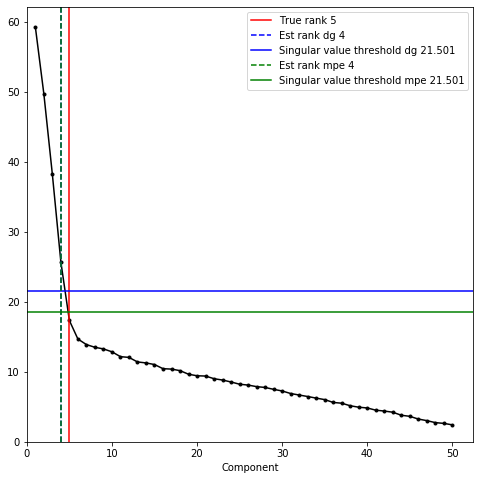

In [61]:
noise_est = estimate_noise_mp_quantile(svals=svals, shape=X.shape, q=.5)
print("noise est", noise_est)

thresh_dg = donoho_gavish_threshold(shape=X.shape, sigma=noise_est)
rank_est_dg = sum(svals > thresh_dg)
print("Estimated rank dg", rank_est_dg)


thresh_mpe = marcenko_pastur_edge_threshold(shape=X.shape, sigma=noise_est)
rank_est_mpe = sum(svals > thresh_mpe)
print("Estimated rank mpe", rank_est_mpe)

plt.figure(figsize=(8, 8))
scree_plot(svals, color='black')
plt.ylim(0)
plt.axvline(rank_true, label='True rank {}'.format(rank_true), color='red')
plt.axvline(rank_est_dg, label='Est rank dg {}'.format(rank_est_dg), color='blue', ls='--')
plt.axhline(thresh_dg, label='Singular value threshold dg {:1.3f}'.format(thresh_dg),  color='blue')

plt.axvline(rank_est_mpe, label='Est rank mpe {}'.format(rank_est_dg), color='green', ls='--')
plt.axhline(thresh_mpe, label='Singular value threshold mpe {:1.3f}'.format(thresh_dg),  color='green')

plt.legend()

### noise estimates

1. Estimate based on the median singular value and the median of the Marcenko-Pastur distrubiton. Other quantiles are available. See (Gavish and Donoho, 2014).


2. Estimate based on SoftImpute cross-validation discussed in (Choi et al. 2017). This can be slower but more accurate than the MP quantile estimator, especially if the signal rank is large.


In [62]:
%%time

# MP quantile estimator is faset
sigma_noise_mp = estimate_noise_mp_quantile(svals, shape=X.shape, q=.5)
print("Noise estimate", sigma_noise_mp, '\n')

Noise estimate 1.1606574346307013 

CPU times: user 7.11 ms, sys: 386 µs, total: 7.49 ms
Wall time: 7.28 ms


In [63]:
%%time

# soft impute cross-validation is slower
simga_noise_est_si, out = estimate_noise_soft_impute(X, c=2 / 3, K=5, n_lambd_vals=100)
print("Noise estimate", simga_noise_est_si)

thresh_dg = donoho_gavish_threshold(shape=X.shape, sigma=simga_noise_est_si)
rank_est_dg = sum(svals > thresh_dg)
print("Estimated rank dg", rank_est_dg)

thresh_mpe = marcenko_pastur_edge_threshold(shape=X.shape, sigma=simga_noise_est_si)
rank_est_mpe = sum(svals > thresh_mpe)
print("Estimated rank mpe", rank_est_mpe, '\n')

Noise estimate 0.988963072265031
Estimated rank dg 4
Estimated rank mpe 5 

CPU times: user 1min 54s, sys: 22.4 s, total: 2min 17s
Wall time: 20.9 s


# Cross-Validation

### Bi-Cross validation (Gabriel style)


Estimated rank 5


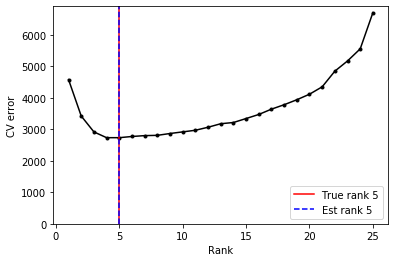

In [64]:
rank_est, out = select_rank_bi_cv(X, rotate=True)
print("Estimated rank", rank_est)


errors = out['errors']
plt.plot(errors.index, errors, marker='.', color='black')
plt.ylim(0)
plt.axvline(rank_true, label='True rank {}'.format(rank_true), color='red')
plt.axvline(rank_est, label='Est rank {}'.format(rank_est), color='blue', ls='--')
plt.xlabel("Rank")
plt.ylabel("CV error")
plt.legend()

### Wold style

Estimated rank 4


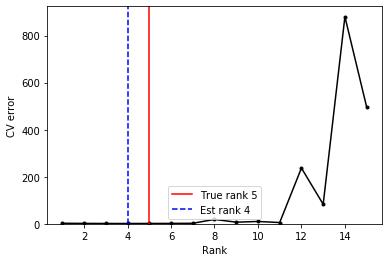

In [65]:
rank_est, out = select_rank_wold_cv(X, max_rank=15, rotate=True)
print("Estimated rank", rank_est)


errors = out['errors']
plt.plot(errors.index, errors, marker='.', color='black')
plt.ylim(0)
plt.axvline(rank_true, label='True rank {}'.format(rank_true), color='red')
plt.axvline(rank_est, label='Est rank {}'.format(rank_est), color='blue', ls='--')
plt.xlabel("Rank")
plt.ylabel("CV error")
plt.legend()

# BIC (Bai and Ng, 2002)

Estimated rank 5 BIC 0
Estimated rank 4 BIC 1
Estimated rank 4 BIC 2
Estimated rank 5 BIC 3


<Figure size 576x576 with 0 Axes>

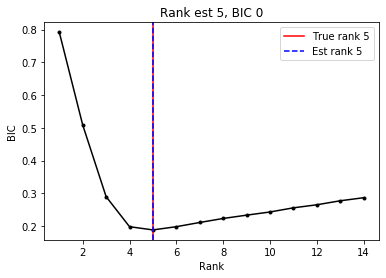

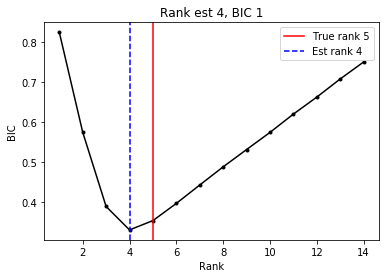

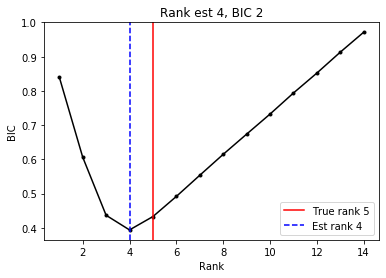

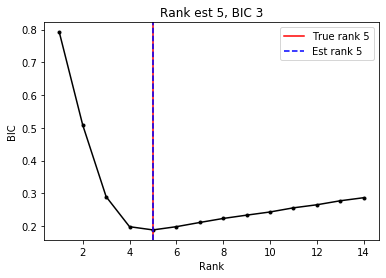

In [66]:
plt.figure(figsize=(8, 8))

for who in range(4):
    rank_est, bic_vals = select_rank_bai_ng_bic(X, who=who, rank_max=15)
    print("Estimated rank", rank_est, 'BIC', who)

    plt.figure()
    plt.title("Rank est {}, BIC {}".format(rank_est, who))
    plt.plot(bic_vals.index, bic_vals, marker='.', color='black')
    plt.axvline(rank_true, label='True rank {}'.format(rank_true), color='red')
    plt.axvline(rank_est, label='Est rank {}'.format(rank_est), color='blue', ls='--')
    plt.xlabel("Rank")
    plt.ylabel("BIC")
    plt.legend()

# Horn

Estimated rank 3


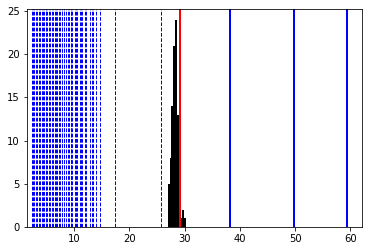

In [70]:
rank_est, out = select_rank_horn(X=X, n_perm=1000)

print("Estimated rank", rank_est)

plot_horn(**out)

# Minka

Estimated rank 5


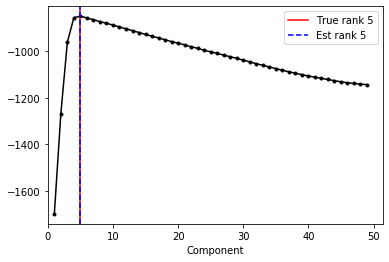

In [71]:
rank_est, out = select_rank_minka(shape=X.shape, svals=svals)
print("Estimated rank", rank_est)


log_liks = out['log_liks']
ranks = np.arange(1, len(log_liks) + 1)
scree_plot(log_liks, color='black')
plt.axvline(rank_true, label='True rank {}'.format(rank_true), color='red')
plt.axvline(rank_est, label='Est rank {}'.format(rank_est), color='blue', ls='--')
plt.legend()

# Profile likelihood

In [72]:
rank_est, out = select_rank_prof_lik(svals=svals)
print("Estimated rank", rank_est)

print(out['elbows'])

Estimated rank 21
[3, 21]
